In [13]:
from pyspark import SparkConf, SparkContext
import datetime
from math import acos, sin, cos, floor
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_shortest_distance(lat1, lon1, lat2, lon2):
    return acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon2 - lon1)) * 6371

In [3]:
def parse_table1(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, 1)

In [4]:
def parse_table2(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    V_AVG = 12/3.6/1000
    startt = datetime.datetime.strptime(startt, '%Y-%m-%dT%H:%M:%S')
    endt = datetime.datetime.strptime(endt, '%Y-%m-%dT%H:%M:%S')
    duration = endt - startt
    #return (bikeid, get_shortest_distance(int(startlt), int(startln), int(endlt), int(endln))) через координаты
    return (bikeid, V_AVG*duration.total_seconds())

In [5]:
def parse_table3(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, startt[0:7])

In [6]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)

23/04/11 00:26:34 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.27 instead (on interface en0)
23/04/11 00:26:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/11 00:26:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
REPAIR_LIM = 1000
REPAIR_PRICE = 1000
BIKE_PRICE = 1000

In [8]:
unique_by_year = []
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"clean_sources/{y}").map(parse_table1) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .map(lambda x: (None, 1)) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .collect()
    unique_by_year.append((y, df[0][1]))
print("Уникальные велосипеды по годам:", unique_by_year)

Уникальные по годам: [(2013, 2887), (2014, 2968), (2015, 4724), (2016, 5543), (2017, 5899), (2018, 6133), (2019, 6017)]


In [36]:
cum_repairs = []
run = []
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"clean_sources/{y}").map(parse_table2) \
                                          .reduceByKey(lambda a, b: a + b)
    '''
    big = big.union(df)
    analyse_rep = big.map(lambda x: (None, floor(x[1] / REPAIR_LIM))) \
                 .reduceByKey(lambda a, b: a + b) \
                 .collect()
    cum_repairs.append((y, analyse_rep[0][1]))
    '''
    analyse_run = df.map(lambda x: (None, x[1])) \
                    .reduceByKey(lambda a, b: a + b) \
                    .collect()
    run.append((y, analyse_run[0][1]))
print("Накопительное количество ремонтов по годам: ", cum_repairs)
print("Пробег по годам: ", run)

Exception in thread "serve RDD 241" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:684)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:650)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:626)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:583)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:540)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)
Exception in thread "serve RDD 253" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:684)
	at java.base/java.net.Serve

Накопительное количество ремонтов по годам:  []
Пробег по годам:  [(2013, 3138680.999999999), (2014, 8386190.2), (2015, 10866616.6), (2016, 4758674.199999997), (2017, 1738614.0000000012), (2018, 16972177.416666668), (2019, 18459430.796666663)]


In [10]:
cum = 0
repairs = []
for y, s in cum_repairs:
    repairs.append((y, s - cum))
    cum = s
print("Количество ремонтов по годам: ", repairs)
repair_prices = [(y, x * REPAIR_PRICE) for y, x in repairs]
print("Затраты на ремонт по годам: ", repair_prices)
print("Средние затраты по годам: ", sum([x for y, x in repair_prices]) / len(repair_prices))

Значение ремонтов по годам:  [(2013, 1791), (2014, 6902), (2015, 8514), (2016, 2288), (2017, 15), (2018, 13928), (2019, 15482)]
Затраты на ремонт по годам:  [(2013, 1791000), (2014, 6902000), (2015, 8514000), (2016, 2288000), (2017, 15000), (2018, 13928000), (2019, 15482000)]
Средние затраты по годам:  6988571.428571428


In [11]:
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"clean_sources/{y}").map(parse_table3)
    big = big.union(df)

unique = big.reduceByKey(lambda a, b: a if a < b else b) \
            .map(lambda x: (x[1], 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .collect()
unique_by_year2 = []
for y in range(2013, 2019 + 1):
    summa = 0
    for d, x in unique:
        if str(y) in d:
            summa += x
    unique_by_year2.append((y, summa))
print("Новые уникальные велосипеды по месяцам:", unique)
print("Новые уникальные велосипеды по годам:", unique_by_year2)
avg_bike = sum([x for y, x in unique_by_year2]) / len(unique_by_year2)
print("Среднее новых по годам: ", avg_bike)
print("Средние затраты на велосипеды: ", avg_bike * BIKE_PRICE)

Уникальные по месяцам: [('2016-06', 694), ('2013-11', 12), ('2017-11', 22), ('2014-04', 3), ('2019-11', 139), ('2018-01', 5), ('2018-05', 1), ('2014-05', 28), ('2015-01', 1), ('2013-10', 345), ('2014-10', 3), ('2015-04', 517), ('2017-10', 682), ('2015-05', 1200), ('2015-03', 3), ('2018-06', 1), ('2018-07', 2), ('2015-06', 40), ('2015-07', 4), ('2014-01', 3), ('2013-12', 66), ('2015-08', 3), ('2018-11', 1), ('2018-10', 1), ('2013-09', 722), ('2013-07', 389), ('2014-09', 2), ('2014-03', 65), ('2017-12', 6), ('2013-06', 598), ('2016-05', 205), ('2013-08', 755)]
Уникальные по годам: [(2013, 2887), (2014, 104), (2015, 1768), (2016, 899), (2017, 710), (2018, 11), (2019, 139)]
Среднее уникальное по годам:  931.1428571428571
Средние затраты на велосипеды:  931142.8571428572


Text(0.5, 0, 'Год')

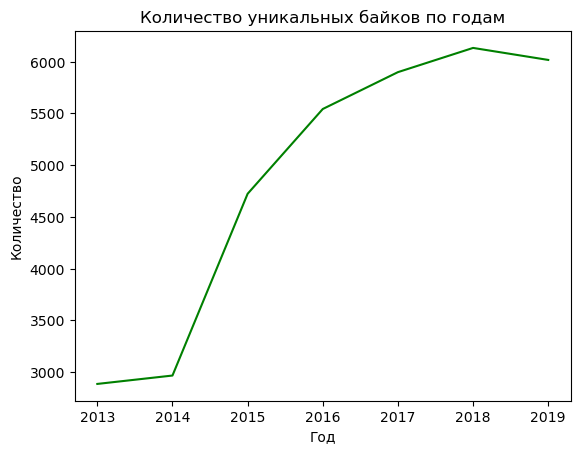

In [32]:
pdf = pd.DataFrame(unique_by_year)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Количество уникальных байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

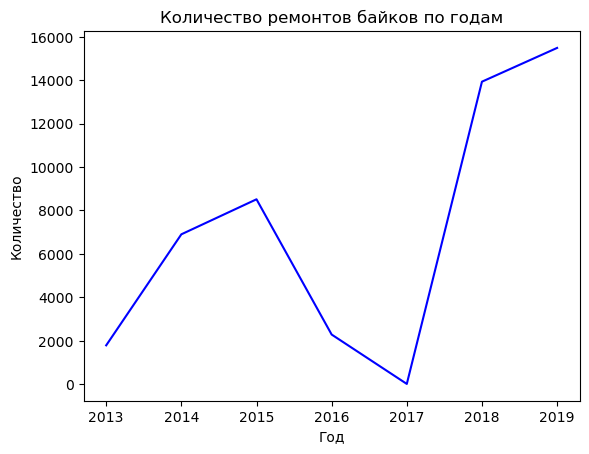

In [28]:
pdf = pd.DataFrame(repairs)
plt.plot(pdf[0], pdf[1], c="blue")
plt.title("Количество ремонтов байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

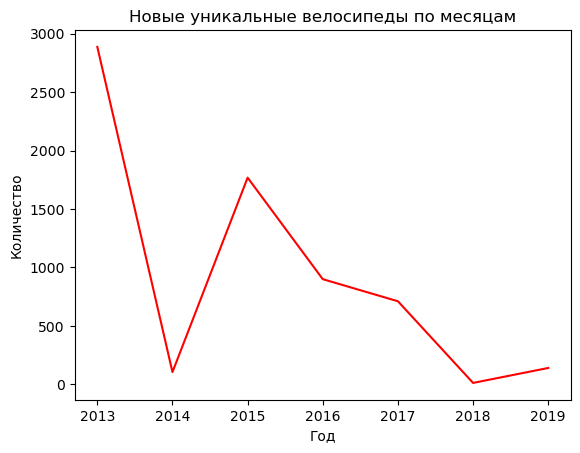

In [31]:
pdf = pd.DataFrame(unique_by_year2)
plt.plot(pdf[0], pdf[1], c="red")
plt.title("Новые уникальные велосипеды по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

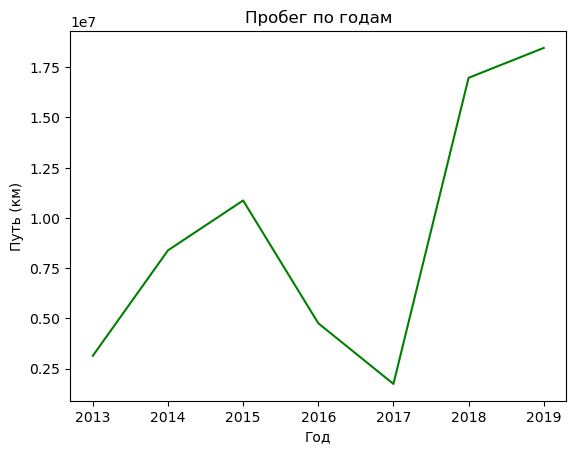

In [37]:
pdf = pd.DataFrame(run)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Пробег по годам")
plt.ylabel("Путь (км)")
plt.xlabel("Год")